In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
import sympy as sym

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18

from scipy.ndimage import gaussian_filter1d



# IMPORT CUSTOM LIBRARIES
from IN8_read_data import gen_data_df_specJun24, load_mus
from functions import *
from alias import *


In [2]:
data = gen_data_df_specJun24('./data/scan_database.tsv', './data/rawdata/')

MSdata = {}
for T in [160, 200, 300]:
    MSdata[T] = pd.read_csv('./data/MSdata/simdata/simdata_'+str(T)+'K.csv')

MU = load_mus()

Qs = [.5, .7, .9, 1.1, 1.5]

# Data Reduction
Here we depict how we reduce the data, subtracting the contributions from the cell and the background. The actual work is done by the red_data.py library, here we just sketch the main steps.

## Experimental parameters
The starting point is the definition of the experimental parameters.

In [3]:
############ Experimental parameters############
kf = 5.8 # Angstrom^-1
Ef = k2E(kf)
r1_vanadium = 1 # mm, vanadium thickness
r2_vanadium = 1.2 # mm, vanadium thickness
r1_sample = 1 # mm, sample thickness
r2_sample = 1.2 # mm, sample thickness
################################################

print('kf =', kf, 'Angstrom^-1')
print('Ef =', Ef, 'meV\n')

print('Cell specifications:')
print('r1_vanadium =', r1_vanadium, 'cm')
print('r2_vanadium =', r2_vanadium, 'cm')
print('r1_sample =', r1_sample, 'cm')
print('r2_sample =', r2_sample, 'cm\n')

kf = 5.8 Angstrom^-1
Ef = 69.70269243254256 meV

Cell specifications:
r1_vanadium = 1 cm
r2_vanadium = 1.2 cm
r1_sample = 1 cm
r2_sample = 1.2 cm



## Calcuation of the trasmission $T$ and self absorption $T_S$
### Trasmission - $T$
To be simulated

In [4]:
Tr = {}
Tr['gly'] = lambda Q, E, T: .85
Tr['V'] = lambda Q, E, T: .85

## Background 
We have all the ingredients for the background subtrction (with or without multiple scattering)!
$$
I(Q,E) = (S(Q,E)-Abs(Q,E)) - T(Q,E)(Empty(Q,E)-Abs(Q,E)) = S - TEmpty - (1-T)Abs
$$
where $S$ is the sample, $Empty$ is the empty cell, and $Abs$ is the absorber measurements. $T$ is both energy and $Q$ dependent, as well as implicitly dependent in the temperature as a consequence of the density change.

In [5]:
red = {}
for T in [160, 200, 300]:
    red[T] = pd.DataFrame(columns=['Q', 'omega', 'I', 'dI', 'Tr', 'Ki', 'Kf'])

In [6]:
for T in [160, 200, 300]:
    for q in Qs:
        omega = data.loc[Ngly[T,q]].data.EN
        I =          data.loc[Ngly[T,q]].data.CNTS    /data.loc[Ngly[T,q]].data.M1    - Tr['gly'](q,omega, T)   *data.loc[Nempty[q]].data.CNTS    /data.loc[Nempty[q]].data.M1    - (1-Tr['gly'](q,omega, T))   *data.loc[Ncad[q]].data.CNTS    /data.loc[Ncad[q]].data.M1
        dI = np.sqrt(data.loc[Ngly[T,q]].data.dCNTS**2/data.loc[Ngly[T,q]].data.M1**2 + Tr['gly'](q,omega, T)**2*data.loc[Nempty[q]].data.dCNTS**2/data.loc[Nempty[q]].data.M1**2 + (1-Tr['gly'](q,omega, T))**2*data.loc[Ncad[q]].data.dCNTS**2/data.loc[Ncad[q]].data.M1**2)
        # check if the varables has nan
        if np.isnan(I).any() or np.isnan(dI).any() or np.isnan(E2k(k2E(kf)+omega)).any() or np.isnan(Tr['gly'](q,omega, T)).any() or np.isnan(omega).any():
            print('T =', T, 'q =', q, 'has nan')
        red[T] = pd.concat([red[T], pd.DataFrame({'Q': q, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['gly'](q,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})], ignore_index=True)

/tmp/ipykernel_169547/1492638705.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  red[T] = pd.concat([red[T], pd.DataFrame({'Q': q, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['gly'](q,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})], ignore_index=True)
/tmp/ipykernel_169547/1492638705.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  red[T] = pd.concat([red[T], pd.DataFrame({'Q': q, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['gly'](q,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})], ignore_

Note that the intensity I is already corrected by the $k_f/k_i$ factor. This because the monitor efficincy is $1/v$ proportional, that is
$$
eff \propto 1/k_i
$$
i.e. the higher the momentum, the lower the efficiency.

## Second harmoni issue

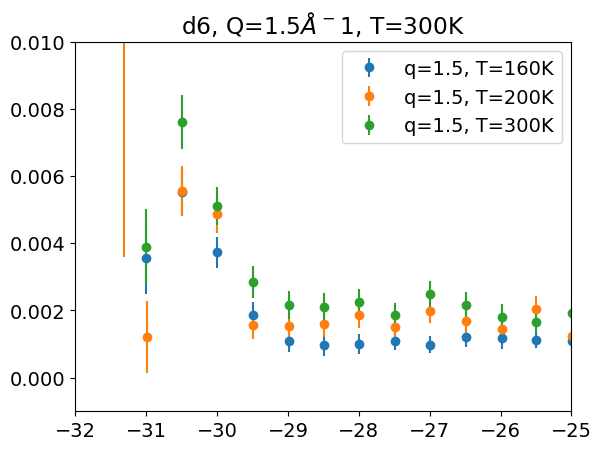

In [8]:
for T in [160, 200, 300]:
    q=1.5
    S = get_spec(red[T], q)
    plt.title(f'd6, Q={q}$\\AA^{-1}$, T={T}K')

    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='q=1.5, T={T}K'.format(T=T))

plt.xlim(-32, -25)
plt.ylim(-.001, .01)
#plt.yscale('log')
plt.legend()

In [9]:
for T in [160, 200, 300]:
    red[T] = red[T][red[300].omega >= -26]
    red[T].reset_index(drop=True, inplace=True)

## Direct beam spikes

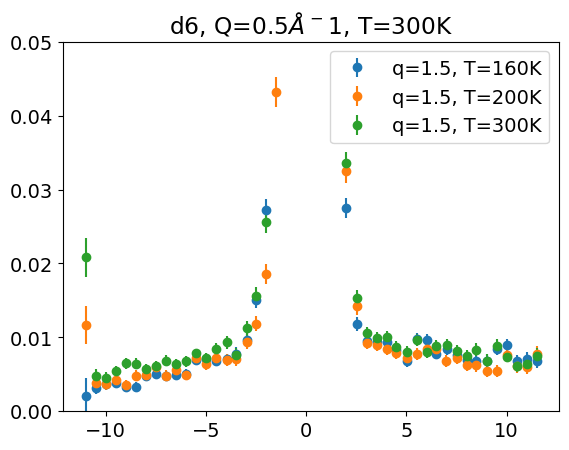

In [11]:
for T in [160, 200, 300]:
    q=.5
    S = get_spec(red[T], q)
    plt.title(f'd6, Q={q}$\\AA^{-1}$, T={T}K')

    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='q=1.5, T={T}K'.format(T=T))

#plt.xlim(-32, -25)
plt.ylim(0, .05)
#plt.yscale('log')
plt.legend()

In [12]:
idx = red[T][(red[T].Q==.5) & (red[T].omega <= -10.7)].index

# dropo idx from red
for T in [160, 200, 300]:
    red[T] = red[T].drop(idx)
    red[T].reset_index(drop=True, inplace=True)

## Gaussian convolution of MS
The results, i.e. $I_s$ and $I_m$, of the simulation should be convoluted with the resolution finction, that is, a gaussian convolution
$$
I_{\text{conv}}(x) = \int I(x') \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{(x-x')^2}{2\sigma^2}\right) dx'
$$
where $\sigma$ is the standard deviation of the resolution function.
We generate this data within the dataframe containing the simulation results.

In [13]:
from data.instrument_resolution import FWHM, domega

In [14]:
domega_sim = np.array(MSdata[200].omega)[1] - np.array(MSdata[200].omega)[0]

In [15]:
for T in [160, 200, 300]:
    # generate sum vector
    MSdata[T]['Is+Im'] = MSdata[T].Is + MSdata[T].Im
    
    # convolve each Q const spectra
    for q in Qs:
        qidx = MSdata[T].index[MSdata[T].Q == q]
        # gaussian convolution
        MSdata[T].loc[qidx, 'Is+Im_conv'] = gaussian_filter1d(MSdata[T].loc[qidx, 'Is+Im'], FWHM/2.355/domega_sim, mode='nearest')
        MSdata[T].loc[qidx, 'Is_conv'] = gaussian_filter1d(MSdata[T].loc[qidx, 'Is'], FWHM/2.355/domega_sim, mode='nearest')
        MSdata[T].loc[qidx, 'Im_conv'] = gaussian_filter1d(MSdata[T].loc[qidx, 'Im'], FWHM/2.355/domega_sim, mode='nearest')
        

### Comparison with the reduced measurements

In [16]:
############### INPUTS ###############
T = 200
q = .5
######################################

S = get_spec(red[T], q)
Ssim = get_spec(MSdata[T], q)

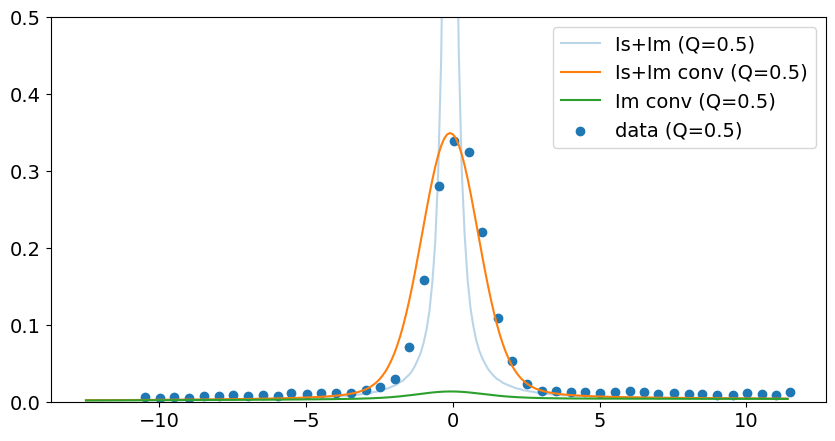

In [17]:
plt.figure(figsize=(10,5))
plt.plot(Ssim.omega, Ssim['Is+Im']/(Ssim['Is+Im'].sum()*domega_sim), label=f'Is+Im (Q={q})', alpha=0.3)
plt.plot(Ssim.omega, Ssim['Is+Im_conv']/(Ssim['Is+Im_conv'].sum()*domega_sim), label=f'Is+Im conv (Q={q})')
plt.plot(Ssim.omega, Ssim['Im_conv']/(Ssim['Is+Im_conv'].sum()*domega_sim), label=f'Im conv (Q={q})')
plt.scatter(S.omega, S.I/(S.I.sum()*domega), label=f'data (Q={q})')

plt.ylim(0,.5)
#plt.xlim(-3,3)

plt.legend()

## MS subtraction

$$
S(q,\omega) = [ \frac{k_f}{k_i} I_{measured}(q,\omega)-I_m(q,\omega)*\frac{\int  \frac{k_f}{k_i}I_{measured}(q,\omega)d\omega}{\int I_s(q,\omega)+I_m(q,\omega)d\omega}] *\frac{k_i}{k_f} *\frac{1}{T_{self}}
$$

In [18]:
from data.instrument_resolution import domega

In [19]:
for T in [160, 200, 300]:
    for q in Qs:
        qidx_sim = MSdata[T].index[MSdata[T].Q == q]
        qidx = red[T].index[red[T].Q == q]

        red[T].loc[qidx, 'Im'] = np.interp(red[T].loc[qidx].omega, MSdata[T].loc[qidx_sim, 'omega'], MSdata[T].loc[qidx_sim, 'Im_conv'] / (MSdata[T].loc[qidx_sim, 'Is+Im_conv'].sum()*domega_sim)) * (np.sum(red[T].loc[qidx, 'Kf']/red[T].loc[qidx, 'Ki']*red[T].loc[qidx, 'I'])*domega)
        red[T].loc[qidx, 'I-Im'] = red[T].loc[qidx, 'Kf']/red[T].loc[qidx, 'Ki'] *red[T].loc[qidx, 'I'] - red[T].loc[qidx, 'Im']
        red[T].loc[qidx, 'S']  = red[T].loc[qidx, 'I-Im'] * red[T].loc[qidx, 'Ki']/red[T].loc[qidx, 'Kf'] * 1/np.interp(red[T].loc[qidx].omega, MSdata[T].loc[qidx_sim, 'omega'], MSdata[T].loc[qidx_sim, 'T_self']) 
        red[T].loc[qidx, 'dS'] = red[T].loc[qidx, 'dI']                                                   * 1/np.interp(red[T].loc[qidx].omega, MSdata[T].loc[qidx_sim, 'omega'], MSdata[T].loc[qidx_sim, 'T_self']) 
    red[T].to_csv(f'./data/reddata/red_{T}K.csv', index=False)

## Reduced data first view

(0.0, 0.03)

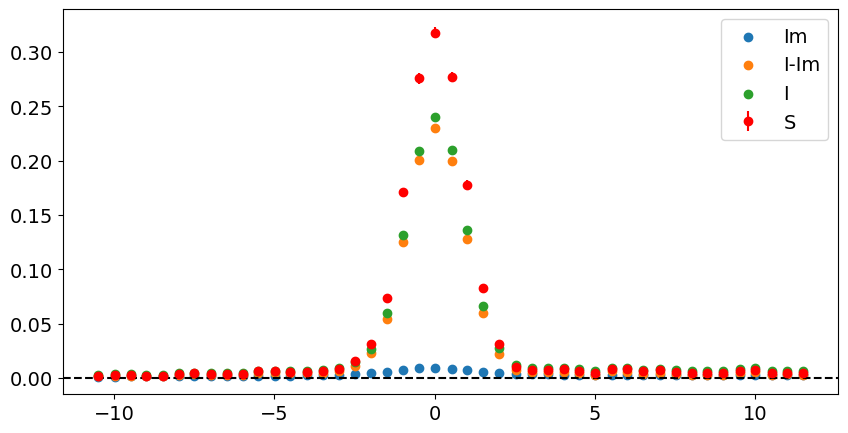

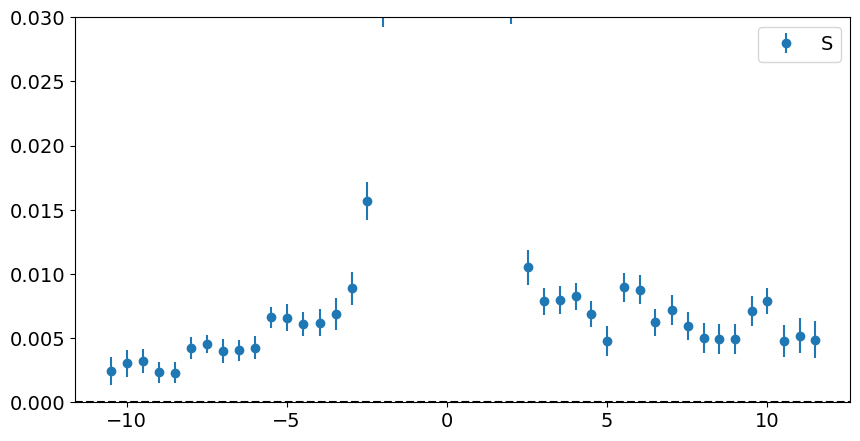

In [20]:
############### INPUTS ###############
T = 160
q = .5
######################################

S = get_spec(red[T], q)

plt.figure(figsize=(10,5))
plt.scatter(S.omega, S.Im, label='Im')
plt.scatter(S.omega, S['I-Im'], label='I-Im')
plt.scatter(S.omega, S.I, label='I')
plt.errorbar(S.omega, S.S, yerr=S.dS, fmt='o', label='S', c='r')
plt.axhline(0, color='k', linestyle='--')
plt.legend()

plt.figure(figsize=(10,5))
plt.errorbar(S.omega, S.S, yerr=S.dS, fmt='o', label='S')
plt.axhline(0, color='k', linestyle='--')
plt.legend()

plt.ylim(0, 0.03)

## 3D plot

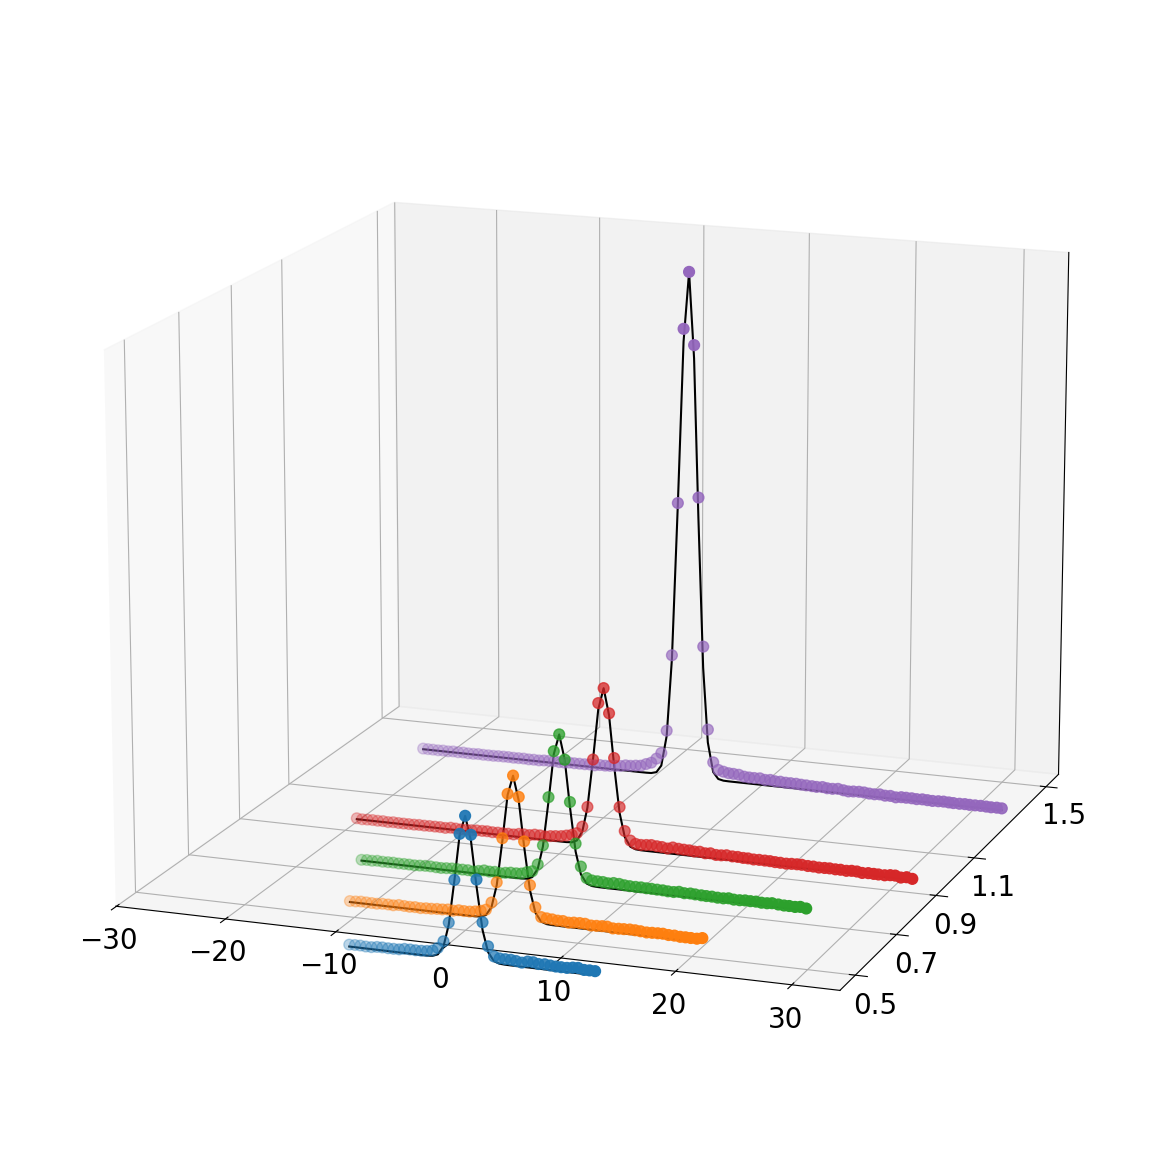

In [21]:
# 3D plot
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection='3d')

gauss = lambda x: np.exp(-.5*((x)/(FWHM/2.355))**2)

for q in Qs:
    S = get_spec(red[T], q)
    ax.scatter3D(S.omega, S.Q, S.I, s=60)
    ax.plot3D(S.omega, S.Q, gauss(S.omega)*S.I.max(), c='black')
    
    

ax.view_init(15, -70)
#plt.xlabel('Energy [meV]', fontsize=20)
#plt.ylabel('Q [$\AA^{-1}$]', fontsize=20)
# z label
ax.set_zticks([])

ax.set_xticks([-30,-20,-10,0,10,20,30])
ax.set_yticks(Qs)
ax.set_zlim(.05)

ax.tick_params(axis='both', which='major', labelsize=20)

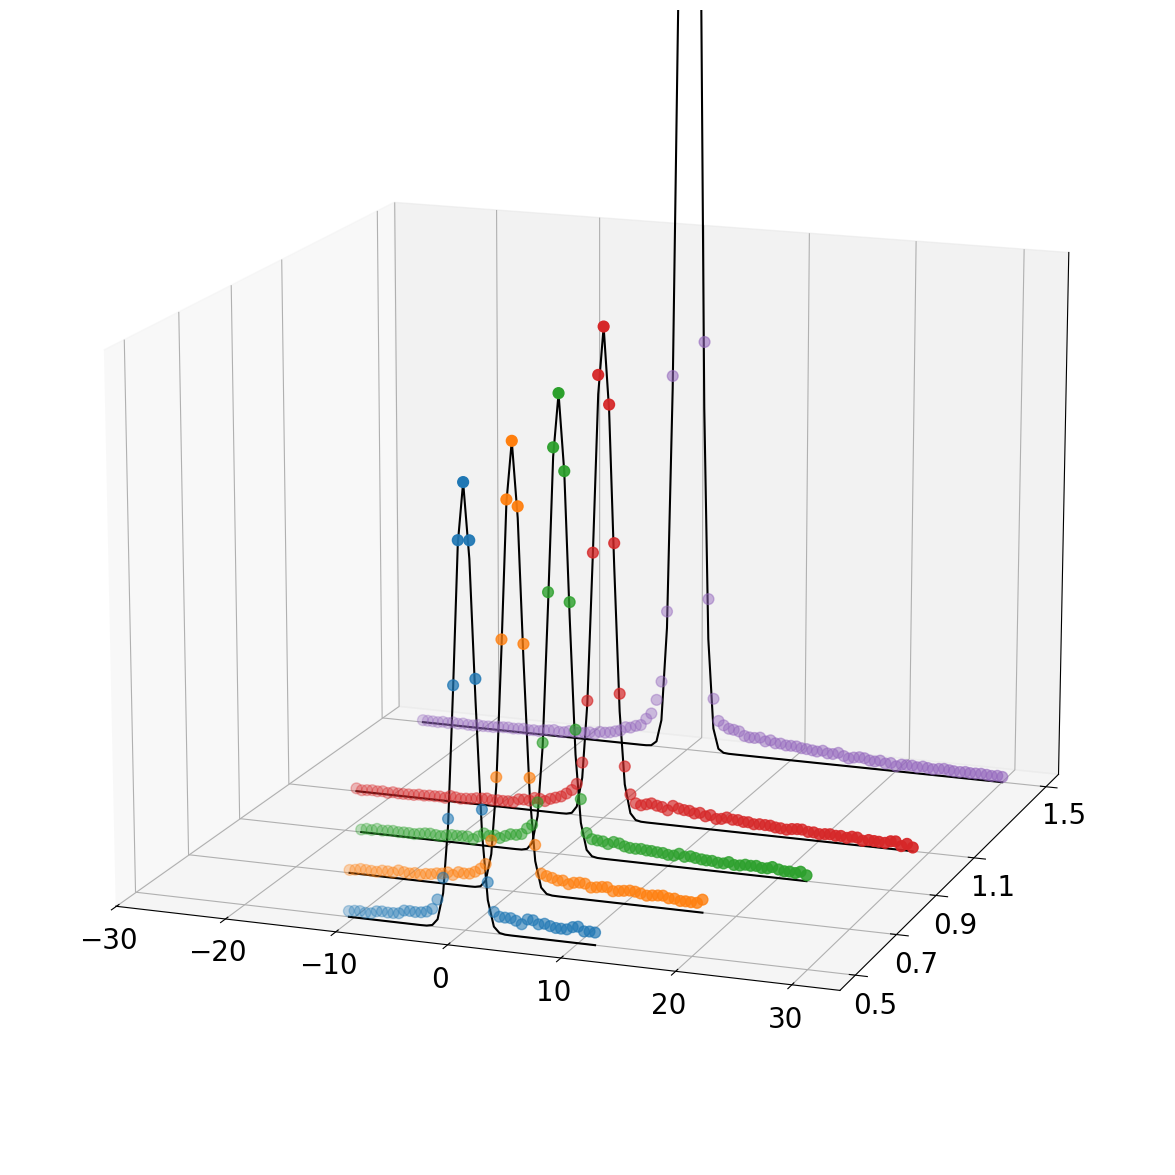

In [22]:
# 3D plot
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection='3d')

gauss = lambda x: np.exp(-.5*((x)/(FWHM/2.355))**2)

for q in Qs:
    S = get_spec(red[T], q)
    ax.scatter3D(S.omega, S.Q, S.I, s=60)
    ax.plot3D(S.omega, S.Q, gauss(S.omega)*S.I.max(), c='black')
    
    

ax.view_init(15, -70)
#plt.xlabel('Energy [meV]', fontsize=20)
#plt.ylabel('Q [$\AA^{-1}$]', fontsize=20)
# z label
ax.set_zticks([])

ax.set_xticks([-30,-20,-10,0,10,20,30])
ax.set_yticks(Qs)
ax.set_zlim(0, .3)

ax.tick_params(axis='both', which='major', labelsize=20)

(0.0001, 0.1)

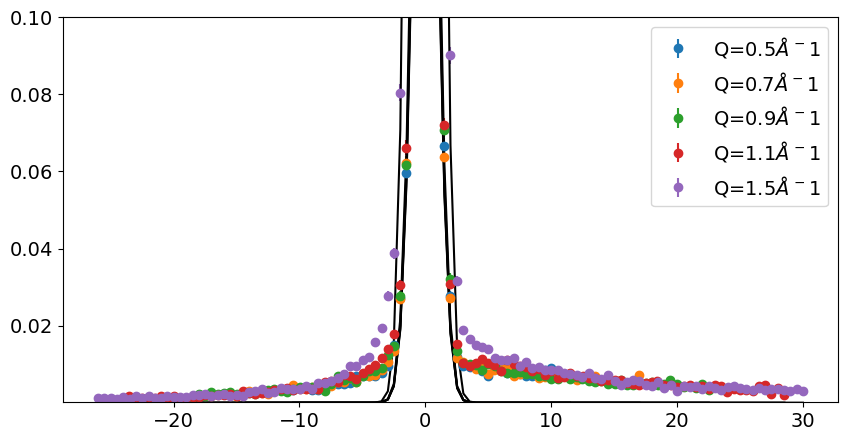

In [24]:
# same above plot but in 2D
plt.figure(figsize=(10,5))
for q in Qs:
    S = get_spec(red[T], q)
    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label=f'Q={q}$\\AA^{-1}$')
    plt.plot(S.omega, gauss(S.omega)*S.I.max(), c='black')
plt.legend()
#plt.yscale('log')
plt.ylim(1e-4, .1)
